In [1]:
import numpy as np
import pandas as pd

import sqlite3

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default='browser'

import scipy as sp
from scipy import sparse
from scipy.fft import fft, ifft
from scipy.linalg import dft
from scipy.signal import find_peaks
from scipy.signal.windows import windows
from scipy.signal import cheby1, sosfilt

from scipy.optimize import curve_fit

from scipy.interpolate import interp1d

%load_ext sql
%sql sqlite:///Event.sqlite

The database is impoted and converted to a pandas dataframe, much better for data analysis in python and also better for exporting the data to numpy

In [2]:
cnx = sqlite3.connect(r'Event.sqlite')

# create the dataframe from a query
df = pd.read_sql_query("SELECT * FROM Event", cnx)

df.drop_duplicates()

,ID,DateTimeEventTT,Satellite,Type1,Type2,Type3,Origin,DateTimeAdded
0,1,2020-01-01 15:17:59,1,OM,D,EXT,Thuillot,2020-12-13 12:52:55
1,2,2020-01-01 15:21:38,1,OM,D,INT,Thuillot,2020-12-13 12:52:55
2,3,2020-01-01 15:23:21,1,PA,D,EXT,Thuillot,2020-12-13 12:52:55
3,4,2020-01-01 15:27:01,1,PA,D,INT,Thuillot,2020-12-13 12:52:55
4,5,2020-01-01 17:32:48,1,OM,F,INT,Thuillot,2020-12-13 12:52:55
...,...,...,...,...,...,...,...,...
703314,757463,2015-12-31 12:57:30,2,PA,D,INT,Thuillot,2021-05-09 23:10:41
703315,757464,2015-12-31 13:18:28,2,OM,F,INT,Thuillot,2021-05-09 23:10:41
703316,757465,2015-12-31 13:22:24,2,OM,F,EXT,Thuillot,2021-05-09 23:10:41
703317,757466,2015-12-31 15:37:46,2,PA,F,INT,Thuillot,2021-05-09 23:10:41


so a short explaination here is much needed. Since the size of the dataframe expanded by inserting phenomena from 2015 to 2021, it became necessary to filter it before the process of comparing the two computations for the phenomena. This sql query will be found in every section of the code, hence will be performed for each moon

# Eclipses

## IO

In [3]:
sql_cmd = """

WITH

PyMeeus AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT, 
Satellite, Type1, Type2, Type3
FROM Event
WHERE ((Origin="PyMeeus") 
AND (Satellite == 1)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
)),

Thuillot AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT
FROM Event
WHERE ((Origin="Thuillot") 
AND (Satellite == 1)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
))


SELECT p.DateTimeEventTT, p.Satellite, p.Type1, p.Type2, p.Type3, 
strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) AS deltaTime, 
MIN( ABS( strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) )) AS minDeltaTime
FROM (PyMeeus p INNER JOIN Thuillot t
ON p.Type = t.Type)
GROUP BY p.DateTimeEventTT
HAVING minDeltaTime <= 3600

"""

df = pd.read_sql_query(sql_cmd, cnx)

Text(0.5, 1.0, 'Variation in eclipse Time for satellite 1 - D')

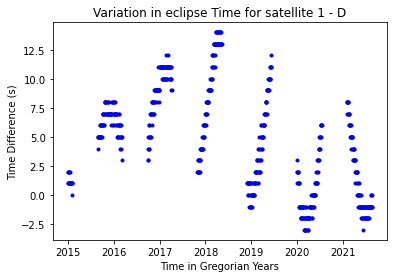

In [4]:
df_EC_INT_IO_INT= df[((df.Satellite == 1)&(df.Type1 == 'EC')&(df.Type2 == 'D')&(df.Type3 == 'INT'))]

df_EC_INT_IO_INT= df_EC_INT_IO_INT[[ 'DateTimeEventTT','deltaTime']]

figure()

dates_int = matplotlib.dates.date2num(df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy())
matplotlib.pyplot.plot_date(dates_int, df_EC_INT_IO_INT['deltaTime'].to_numpy(), 'b.')

plt.ylabel('Time Difference (s)')
plt.xlabel('Time in Gregorian Years')
plt.title('Variation in eclipse Time for satellite 1 - D')

now it becomes necessaire to identify the portions of the s(t) function which is multiplied with the underlaying one in the time domain, in order to filter the effects of it out of the spectrum

In [5]:
datetime_array = df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy()

df_unix_sec = pd.to_datetime(df_EC_INT_IO_INT['DateTimeEventTT']).astype(int)/ 10**9

first_sampling_time = df_unix_sec[0]

relative_sampling_time = df_unix_sec - first_sampling_time

#now we must find samples that are more than three days apart, usually the orbital period is somewhat like 6 days, so everything is ok

samples_diff_vec = np.zeros(len(relative_sampling_time)-1)

for i in range (len(relative_sampling_time)-1):

    samples_diff_vec[i] = relative_sampling_time[i+1] - relative_sampling_time[i]


hot_positions = samples_diff_vec > 180000*2

#print(hot_positions)

#identify positions limits for the s(t) function

s_limits = np.zeros(len(relative_sampling_time))


for i in range (len(hot_positions)):

    if(hot_positions[i]):
    
        s_limits[i] = relative_sampling_time[i]
        i = i+1
        s_limits[i] = relative_sampling_time[i]


non_zero_indices = (np.nonzero(s_limits))[0]

s_t = np.zeros(int(max(relative_sampling_time)))

i = 0

while i in range(np.size(non_zero_indices)-1):
    
    l_index = non_zero_indices[i]
    tmp = i+1
    i = i+1
    r_index = non_zero_indices[tmp]
    i = i+1

    for e in range(int(relative_sampling_time[l_index]), int(relative_sampling_time[r_index])):
        s_t[e] = 1.0

s_t_sparse=sparse.csr_matrix(s_t)

now we must find samples that are more than three days apart, usually the orbital period is somewhat like 1.17  days this is done to find s(t)

Text(0.5, 1.0, 'Windowing Function (downsampled by factor 32), Satellite 1 - D')

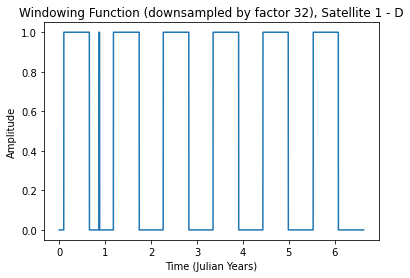

In [6]:
local_donwnsampling_factor = 32

#create yeras linespace
julian_years_linspace = np.linspace(0, (len(s_t)-1)/(3600*24*365.25), len(s_t))
plt.plot(julian_years_linspace[::local_donwnsampling_factor], s_t[::local_donwnsampling_factor])

plt.ylabel('Amplitude')
plt.xlabel('Time (Julian Years)')
plt.title('Windowing Function (downsampled by factor 32), Satellite 1 - D')

For Io this really looks like a periodic square function, so we know it's spectrum. We will now compute it, since s(t) is still in seconds we need to downsample the vector a bit before plotting it and before computing it's fft

Text(0.5, 1.0, "Spectrum of IO's windowing function")

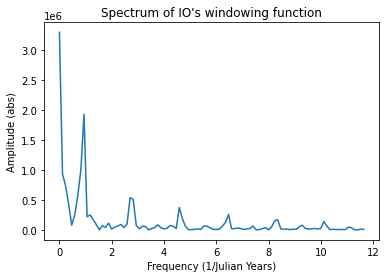

In [7]:
#compute fft_size
fft_size = int(np.ceil(np.log2(len(s_t)/local_donwnsampling_factor)))

#sampling frequency in seconds
t_s = (1*local_donwnsampling_factor)/(365.25*24*3600)

freq = np.fft.fftfreq(2**fft_size, d=t_s)

s_jump_spectrum = fft(s_t[::local_donwnsampling_factor], 2**fft_size)

#only plot to 100 frequency bins, we are only interestd in the lowermost section of the spectrum
plt.plot(freq[0:100],np.abs(s_jump_spectrum[0:100]))

plt.ylabel('Amplitude (abs)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of IO\'s windowing function')

perform the FFT

the periods we want to be able to see are 1y and 10y (ish). The overall sampling time is 5 years, menaning that we
need to at least extend the portion of the function considered, such that the lowermost frequencies can migrate
in a discernable bin, other than the 0, this is currently not possible since we do not have any other data, so we will go for
a regression in a later step

later on we will notice that it is nedde possible to discerene those frequencies for Europa and Gynmede

we are measuring everything in seconds, we don't really need that precision, let's switch to hours instead,
this will reduce the size of the data to 50 thousands points

well, the vector we used before for the eclipse data was dense until now, we should make it a sparse to compute the fft

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0.5, 1.0, "Spectrum of IO's windowing function")

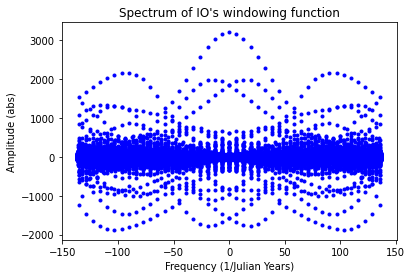

In [8]:
#now we have to generate the remianing data from the eclipse difference time data

eclipse_diff_data = np.zeros(int(max(relative_sampling_time)))


time_diff_data_sparse = df_EC_INT_IO_INT['deltaTime'].to_numpy()


for i in range(len(relative_sampling_time)-1):
    
    timestamp = int(relative_sampling_time[i])
    
    eclipse_diff_data[timestamp] = time_diff_data_sparse[i]
    
#perform the FFT

n_samples_per_bin = 3600 #seconds in an hour, basic time bin units

binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

#print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_hours = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_hours[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])  
    
    
#perform the FFT on the binned data
fft_size = 2**int(np.ceil(np.log2(len(binned_eclipse_data_hours))))

s_spectrum = fft(binned_eclipse_data_hours[:], fft_size)

#sampling frequency in seconds
t_s = (1*3600*local_donwnsampling_factor)/(365.25*24*3600)
freq = np.fft.fftfreq(fft_size, d=t_s)

plt.plot(freq, s_spectrum[:], 'b.')

plt.ylabel('Amplitude (abs)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of IO\'s windowing function')

quick visual verification of the data

this spectrum will highly likely have a lot of harmonics in it, coming frmo s(t), the windowing (si-Function) and some aliasing deriving from the HF-changes caused by noise between adjacent values

this is not a particularry good result, there are too many variables variating the spectrum, hence too many harmonics we should filter it before we proceed

Text(0.5, 1.0, "Spectrum of IO's delta times")

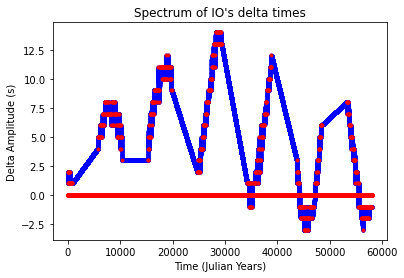

In [9]:
#cubic interpolation is actually way worse for the FFT part, so let's just do a simple linear one

hours_linspace = np.linspace(0, len(binned_eclipse_data_hours)-1, len(binned_eclipse_data_hours))

idx = np.nonzero(binned_eclipse_data_hours)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_hours[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(hours_linspace[:])

plt.plot(eclipse_data_interp, 'b.')
plt.plot(binned_eclipse_data_hours, 'r.')

plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time (Julian Years)')
plt.title('Spectrum of IO\'s delta times')

with the interpolation we basically generate data where there is none, the underlayng assumption is that the data has to have a sin form

let's now petfrom an FFT on the data, this time with a special spectrum resolution

it looks like there are some clerar peaks

[ 460  745 1068 1510 2586 3275]


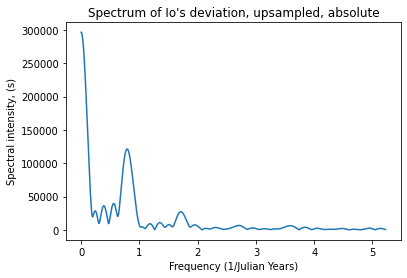

In [10]:
#zero pad for higher resolutioin
zero_pad = np.zeros(2**24-len(eclipse_data_interp))
s_interp = fft(np.append(eclipse_data_interp, zero_pad))

t_s = (1*3600)/(365.25*24*3600)

freq = np.fft.fftfreq(2**24, d=t_s)

plt.ylabel('Spectral intensity, (s)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of Io\'s deviation, upsampled, absolute')
plt.plot(freq[0:10000], np.abs(s_interp[0:10000]))

peaks, _ = find_peaks(np.abs(s_interp[0:int(len(s_interp)/2)]), height=10**4)
print(peaks)

Frequency components : (1/Julian Years)
[0.24034739 0.38925827 0.55802393 0.78896642 1.71116889]


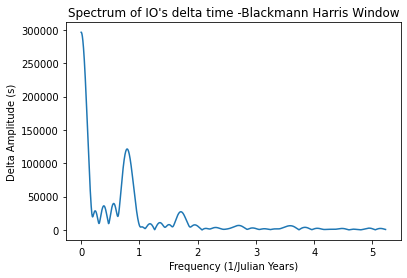

In [11]:
#here I will try to clean the signal using a window, actually we should see way less disturbances in the HF zone, nevertheless we are not really interested in it since they mainly come from the junp-function
w = windows.blackmanharris(len(eclipse_data_interp)) 

zero_pad = np.zeros(2**24-len(eclipse_data_interp))

s_interp_window = eclipse_data_interp*w

s_interp_zeropad_window = np.append(eclipse_data_interp,zero_pad)

s_interp = fft(s_interp_zeropad_window)

plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of IO\'s delta time -Blackmann Harris Window')

plt.plot(freq[0:10**4], np.abs(s_interp[0:10**4]))

peaks, _ = find_peaks(np.abs(s_interp[0:int(len(s_interp)/2)]), height=25*10**3)

print("Frequency components : (1/Julian Years)")

print(freq[peaks])

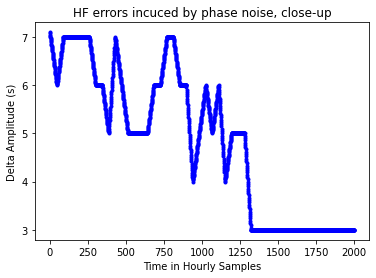

In [12]:
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in Hourly Samples')
plt.title('HF errors incuced by phase noise, close-up')

plt.plot(eclipse_data_interp[9000:11000], 'b.')

there is a lot of noise coming from this phenomena regarding the linear interpolation, we decrease the temporal resolution

let's try to reconstruct the signal back only using some of the harmonics up to the first peak(sample ~1500)

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part



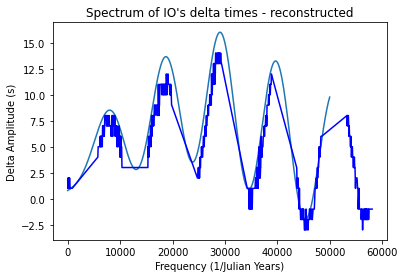

In [13]:
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of IO\'s delta times - reconstructed')

plt.plot(ifft(np.append(s_interp[0:2*10**3], zero_pad)*2.5)[0:50*10**3])
plt.plot(eclipse_data_interp, 'b')

the reconstruction looks really fine, now switching to a daily resolution, the function needs to be multiplied with the jump function to obtain some acceptable results out of it, now we will compute the spectrum of the eclipse-delta function multiplied with the windowing function

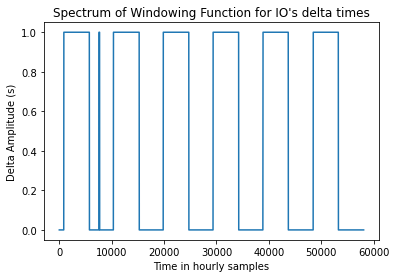

In [14]:
#twoi things are happening here : 
#1) downsampling of the windowing function
#2) the switchings will be way smoother, hence less HF effects 

np.append(s_t, zeropad_vec)

s_t_hrs = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    s_t_hrs[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])
    
    
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Spectrum of Windowing Function for IO\'s delta times')
    
plt.plot(s_t_hrs)

Peaks at : (in 1/Julian Years)
[0.89555526 1.70751143 2.76085997]


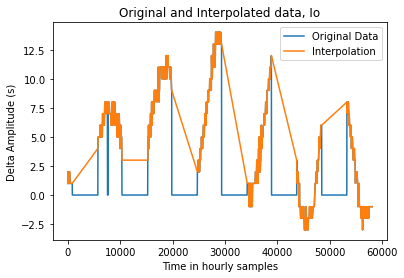

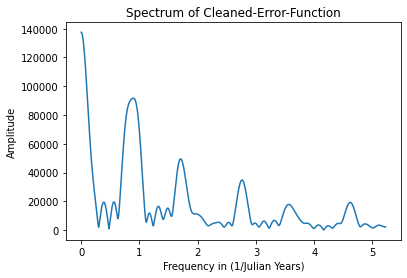

In [15]:
#now I will try to clean out the mess made by the windowing function by setting every element of the arry to zero where the windowing function happens to be

cleaned_array = eclipse_data_interp * (1-s_t_hrs)

plt.figure(1)
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Original and Interpolated data, Io')


plt.plot(cleaned_array)
plt.plot(eclipse_data_interp)
plt.legend(('Original Data','Interpolation'))

#here I will perform an fft
s_cleaned = fft(np.append(cleaned_array, zero_pad))

plt.figure(2)

plt.ylabel('Amplitude')
plt.xlabel('Frequency in (1/Julian Years)')
plt.title('Spectrum of Cleaned-Error-Function')

plt.plot(freq[0:10**4], abs(s_cleaned[0:10**4]))

peaks, _ = find_peaks(np.abs(s_cleaned[0:int(len(s_cleaned)/2)]), height=3*10**4)
print('Peaks at : (in 1/Julian Years)')
print(freq[peaks])

Inserting the windowing function implies generating a lot of secondary peaks in the fourier transform, so this action actually has the effct of making the spectrumn of trhe signal much worse, and needs to be reverted, nevre the less I have tested a lot of things regaring the possibility of filling in the gaps with a function interpolated with a filter.

By chinging the cut-off frequency of the filter er get a more or less resposiveness. Every cut-off frequency we wanna use has the problem of acting like a PID-element reacting to a jump-function, and will generate any kind of artifact in the HF frequency range.

58106


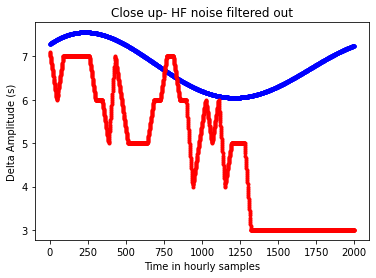

In [16]:
#filter out the HF components resulting from the effect of rounding off to 1 sec

sos = sp.signal.cheby1(10, 0.001, 0.001, 'low', analog=False, output = 'sos')

filtered = sp.signal.sosfilt(sos, eclipse_data_interp*(1-s_t_hrs))

print(len(eclipse_data_interp))

plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Close up- HF noise filtered out')

plt.plot(filtered[9000:11000], 'b.')
plt.plot(eclipse_data_interp[9000:11000], 'r.')

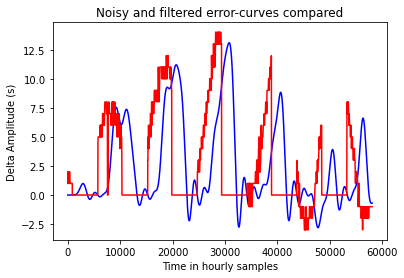

In [17]:
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Noisy and filtered error-curves compared')

plt.plot(filtered[:], 'b')
plt.plot(cleaned_array[:], 'r')

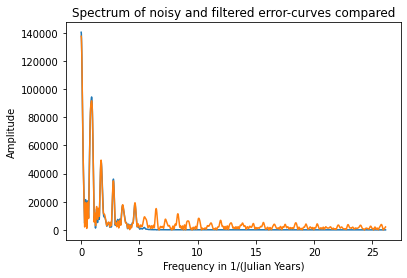

In [18]:
s_cleaned_cheby = fft(np.append(filtered, zero_pad))

plt.ylabel('Amplitude')
plt.xlabel('Frequency in 1/(Julian Years)')
plt.title('Spectrum of noisy and filtered error-curves compared')

plt.plot(freq[0:5*10**4], np.abs(s_cleaned_cheby[0:5*10**4]))
plt.plot(freq[0:5*10**4], np.abs(s_cleaned[0:5*10**4]))

this is the spectrum of the jump-function, As it is nearly periodic, it clearlyhows the effct of windowind on it. (si(t)-function), As you can guess, convoluting them will clerly give us a "double peak" at around 1500 frequency bins. Mybe we should try chaingin the window

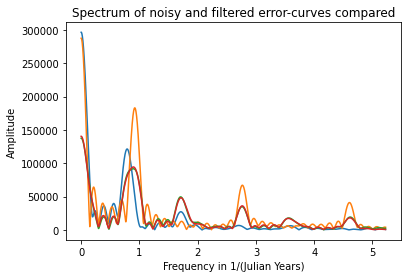

In [19]:
plt.ylabel('Amplitude')
plt.xlabel('Frequency in 1/(Julian Years)')
plt.title('Spectrum of noisy and filtered error-curves compared')

fft_s_t_upsample = fft(np.append(1-s_t_hrs , zero_pad)) 
plt.plot(freq[0:10**4], np.abs(fft(np.append(eclipse_data_interp, zero_pad))[0:10**4]))
plt.plot(freq[0:10**4], np.abs(fft_s_t_upsample)[0:10**4]*10)
plt.plot(freq[0:10**4], np.abs(s_cleaned[0:10**4]))
plt.plot(freq[0:10**4] ,np.abs(s_cleaned_cheby[0:10**4]))

Peaks at : (in 1/Julian Years)
[ 0.78844392 -0.78844392]


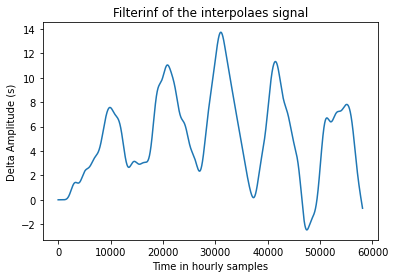

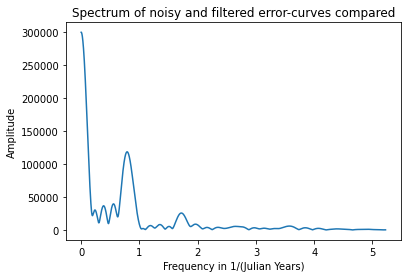

In [20]:
#filter the interpolated data

filtered_interp = sp.signal.sosfilt(sos, eclipse_data_interp)
s_cleaned_cheby_interp = fft(np.append(filtered_interp, zero_pad))


plt.figure(1)
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Filterinf of the interpolaes signal')
plt.plot(filtered_interp)

plt.figure(2)
plt.ylabel('Amplitude')
plt.xlabel('Frequency in 1/(Julian Years)')
plt.title('Spectrum of noisy and filtered error-curves compared')

plt.plot(freq[0:10**4], np.abs(s_cleaned_cheby_interp[0:10**4]))

peaks, _ = find_peaks(np.abs(fft(np.append(filtered_interp, zero_pad))), height=4.5*10**4)
print('Peaks at : (in 1/Julian Years)')
print(freq[peaks])

Interrestingly enough, this windowing function gives almost the same spectrum as the origian function, this is a normal consequence of it near periodic behaviour

Well, apparently there is no advantage of filtering it all before we do the fft, I will just compute the correlatiopn function to make sure taht we did nothing wrong

58106
[ True  True  True ...  True  True  True]
Parameters
0.8018005215721449 3.5424915618416635 5.549127672395715 0.20554746625816528 3.6880093043510063 2.231653643926497 5.579730136555121
Covariance
[[ 2.24934904e-08 -5.02693435e-07 -9.92716918e-08 -2.29826806e-09
   2.79685062e-07  1.12574679e-07  8.11591536e-09]
 [-5.02693435e-07  1.54186482e-05  3.35046625e-06  2.62758250e-07
  -1.02900634e-05 -1.21802922e-05 -5.81402321e-06]
 [-9.92716918e-08  3.35046625e-06  1.16628280e-04  1.97952461e-06
  -6.44172945e-05 -7.00215152e-06  1.11416472e-05]
 [-2.29826806e-09  2.62758250e-07  1.97952461e-06  1.79029182e-07
  -4.50513101e-06  7.08801459e-09  2.63439536e-07]
 [ 2.79685062e-07 -1.02900634e-05 -6.44172945e-05 -4.50513101e-06
   1.36299610e-04  1.30631268e-06 -1.24286680e-05]
 [ 1.12574679e-07 -1.21802922e-05 -7.00215152e-06  7.08801459e-09
   1.30631268e-06  1.14503480e-04  3.17132259e-05]
 [ 8.11591536e-09 -5.81402321e-06  1.11416472e-05  2.63439536e-07
  -1.24286680e-05  3.17132259e-

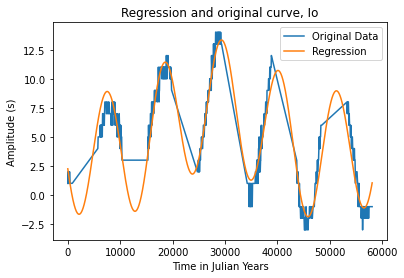

In [21]:
#curve fitting

def func(time, f_1, phi_1, amplitude_1, f_2, phi_2, amplitude_2, offset):

    return offset + amplitude_1*np.sin(f_1*2*np.pi*time/(24*365.25) + phi_1) + amplitude_2*np.sin(f_2*2*np.pi*time/(24*365.25) + phi_2)

hrs_linspace = np.linspace(0, len(s_t_hrs)-1, len(s_t_hrs))


mask = (1-s_t_hrs)

print(np.size(s_t_hrs))

mask = np.array(mask, dtype = 'bool')

print(mask)

values_w_nan = np.zeros(len(eclipse_data_interp))

values_w_nan[(1-s_t_hrs)==0] = np.nan
values_w_nan[(1-s_t_hrs)!=0] = eclipse_data_interp[(1-s_t_hrs)!=0]

popt_IO, pcov = curve_fit(func, hrs_linspace[mask], eclipse_data_interp[mask], maxfev=10**4, 
                       bounds=([0.1,0,0,0.05,0,0,-7],[1.5, 2*np.pi, 7,0.25,2*np.pi,20,+10]), #0,25 actuall delibvers a better looking optiocal fit, don't know why
                       )#sigma = (1-s_t_days)+0.00001)

print("Parameters")
print(*popt_IO)
print("Covariance")
print(pcov)


plt.ylabel('Amplitude (s)')
plt.xlabel('Time in Julian Years')
plt.title('Regression and original curve, Io')
plt.plot(eclipse_data_interp[:])
plt.plot(func(hrs_linspace[:],*popt_IO))
plt.legend(['Original Data', 'Regression'])


In [22]:
def rmse_fit(time, f1, f2, phi_1, amplitude_1, phi_2, amplitude_2, offset, meas_data):
    return np.sqrt(np.sum(func(time, f1, phi_1, amplitude_1, f2, phi_2, amplitude_2, offset) - meas_data)**2)

points_per_side = 1*10**2

f_1_arr = np.linspace(-5, 5 ,points_per_side)
f_2_arr = np.linspace(-1, 1, points_per_side)

f1_v, f2_v = np.meshgrid(f_1_arr, f_2_arr, sparse=False, indexing='ij')

#['f_1', 'phi_1', 'amplitude_1', 'f_2', 'phi_2', 'amplitude_2', 'offset']

phi_1_gan = (popt_IO)[1]
phi_2_gan = (popt_IO)[4]
amplitude_1_gan = (popt_IO)[2]
amplitude_2_gan = (popt_IO)[5]
offset_gan = (popt_IO)[6]

error_matrix = np.zeros([np.size(f_1_arr), np.size(f_1_arr)])

for i in range (np.size(f_1_arr)):
    
    for j in range (np.size(f_1_arr)):        
        
        error_matrix[i, j] = rmse_fit(hrs_linspace[mask], f1_v[i, j], f2_v[i, j], phi_1_gan, amplitude_1_gan, phi_2_gan, amplitude_2_gan, offset_gan,eclipse_data_interp[mask])

In [23]:
fig_error_2d = px.imshow(error_matrix)
fig_error_2d.update_layout(title="IO -2D Error Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_error_2d.show()

fig_inv_err_log_2d = px.imshow(np.log10(1/error_matrix))
fig_inv_err_log_2d.update_layout(title="IO -2D Inv-Log-Error Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_inv_err_log_2d.show()

scene = dict(
    xaxis = dict( title='X AXIS TITLE'),
    yaxis = dict( title='Y AXIS TITLE'),
    zaxis = dict( title='Z AXIS TITLE'))

fig_error_3d = go.Figure(go.Surface(

    x = f_1_arr,
    y = f_2_arr,
    z = error_matrix))

fig_error_3d.update_layout(title="IO -3D Error Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_error_3d.show()

fig_exactness_3d = go.Figure(go.Surface(

    x = f_1_arr,
    y = f_2_arr,
    z = (1/error_matrix)

))
fig_exactness_3d.update_layout(title="IO -3D Exactness Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_exactness_3d.show()

fig_exactness_3d.show()

# EUROPA

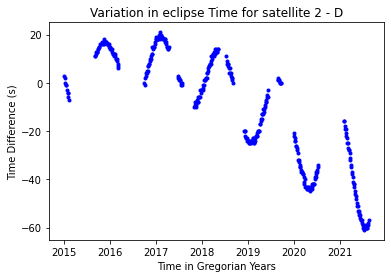

In [17]:
# create the dataframe from a query
df = pd.read_sql_query("SELECT * FROM Event", cnx)

sql_cmd = """

WITH

PyMeeus AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT, 
Satellite, Type1, Type2, Type3
FROM Event
WHERE ((Origin="PyMeeus") 
AND (Satellite == 2)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
)),

Thuillot AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT
FROM Event
WHERE ((Origin="Thuillot") 
AND (Satellite == 2)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
))


SELECT p.DateTimeEventTT, p.Satellite, p.Type1, p.Type2, p.Type3, 
strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) AS deltaTime, 
MIN( ABS( strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) )) AS minDeltaTime
FROM (PyMeeus p INNER JOIN Thuillot t
ON p.Type = t.Type)
GROUP BY p.DateTimeEventTT
HAVING minDeltaTime <= 3600

"""

df = pd.read_sql_query(sql_cmd, cnx)

#now do the same for europa --> load the data

df_EC_INT_EUROPA_INT= df[((df.Satellite == 2)&(df.Type1 == 'EC')&(df.Type2 == 'D')&(df.Type3 == 'INT'))]

df_EC_INT_EUROPA_INT= df_EC_INT_EUROPA_INT[[ 'DateTimeEventTT','deltaTime']]

dates_int = matplotlib.dates.date2num(df_EC_INT_EUROPA_INT['DateTimeEventTT'].to_numpy())
matplotlib.pyplot.plot_date(dates_int, df_EC_INT_EUROPA_INT['deltaTime'].to_numpy(), 'b.')

plt.ylabel('Time Difference (s)')
plt.xlabel('Time in Gregorian Years')
plt.title('Variation in eclipse Time for satellite 2 - D')

datetime_array = df_EC_INT_EUROPA_INT['DateTimeEventTT'].to_numpy()

df_unix_sec = pd.to_datetime(df_EC_INT_EUROPA_INT['DateTimeEventTT']).astype(int)/ 10**9

#print(df_unix_sec)

first_sampling_time = df_unix_sec[0]

relative_sampling_time = df_unix_sec - first_sampling_time

#print(relative_sampling_time)

[  9  10  59  60 114 115 124 125 177 178 193 194 248 249 257 258 313 314]


Text(0.5, 1.0, 'Jump function for satellite 2 - D')

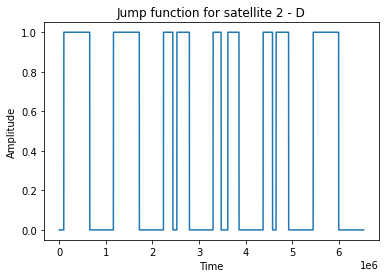

In [18]:
#now we must find samples that are more than three days apart, usually the orbital period is somewhat like 6 days, so everything is ok

samples_diff_vec = np.zeros(len(relative_sampling_time)-1)

for i in range (len(relative_sampling_time)-1):

    samples_diff_vec[i] = relative_sampling_time[i+1] - relative_sampling_time[i]

    
#print(samples_diff_vec)

hot_positions = samples_diff_vec > 160000*5

#print(hot_positions)

#identify positions limits for the s(t) function

s_limits = np.zeros(len(relative_sampling_time))


for i in range (len(hot_positions)):

    if(hot_positions[i]):
    
        s_limits[i] = relative_sampling_time[i]
        i = i+1
        s_limits[i] = relative_sampling_time[i]

#print(s_limits)

non_zero_indices = (np.nonzero(s_limits))[0]


print(non_zero_indices)

s_t = np.zeros(int(max(relative_sampling_time)))

i = 0

while i in range(np.size(non_zero_indices)-1):
    
    l_index = non_zero_indices[i]
    #print(l_index)
    tmp = i+1
    i = i+1
    r_index = non_zero_indices[tmp]
    i = i+1

    #print(r_index)
    
    #print(int(relative_sampling_time[l_index]))
    #print(int(relative_sampling_time[r_index]))
    #print('---')
    
    for e in range(int(relative_sampling_time[l_index]), int(relative_sampling_time[r_index])):
        s_t[e] = 1.0
        #print(int(relative_sampling_time[l_index]))
        
        

#print(s_t)
 
#print(np.sum(s_t))

s_t_sparse=sparse.csr_matrix(s_t)

local_downsampling_factor = 32
    
plt.figure(1)    
plt.plot(s_t[::local_downsampling_factor])
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title('Jump function for satellite 2 - D')

#spectrum of the jump function 

Text(0.5, 1.0, "Spectrum of EUROPA's windowing function")

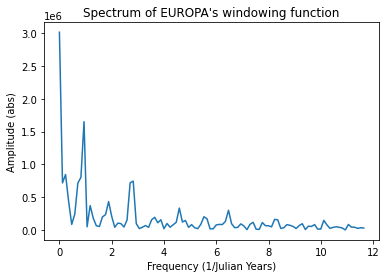

In [19]:
local_downsampling_factor = 32

#compute fft_size
fft_size = int(np.ceil(np.log2(len(s_t)/local_downsampling_factor)))

#sampling frequency in seconds
t_s = (1*local_downsampling_factor)/(365.25*24*3600)

freq = np.fft.fftfreq(2**fft_size, d=t_s)

s_jump_spectrum = fft(s_t[::local_downsampling_factor], 2**fft_size)

#only plot to 100 frequency bins, we are only interestd in the lowermost section of the spectrum
plt.plot(freq[0:100],np.abs(s_jump_spectrum[0:100]))

plt.ylabel('Amplitude (abs)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of EUROPA\'s windowing function')

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0.5, 1.0, "Spectrum of EUROPA's error function")

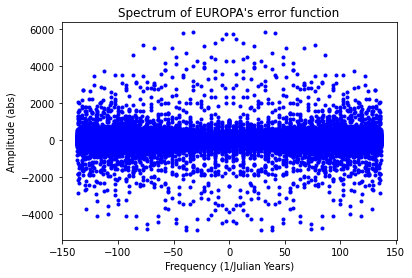

In [20]:
#now we have to generate the remianing data from the eclipse difference time data

eclipse_diff_data = np.zeros(int(max(relative_sampling_time)))


time_diff_data_sparse = df_EC_INT_EUROPA_INT['deltaTime'].to_numpy()


for i in range(len(relative_sampling_time)-1):
    
    timestamp = int(relative_sampling_time[i])
    
    eclipse_diff_data[timestamp] = time_diff_data_sparse[i]
    
#perform the FFT

n_samples_per_bin = 3600 #seconds in an hour, basic time bin units

binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

#print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_hours = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_hours[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])  
    
    
#perform the FFT on the binned data
fft_size = 2**int(np.ceil(np.log2(len(binned_eclipse_data_hours))))

s_spectrum = fft(binned_eclipse_data_hours[:], fft_size)

#sampling frequency in seconds
t_s = (1*3600*local_downsampling_factor)/(365.25*24*3600)
freq = np.fft.fftfreq(fft_size, d=t_s)

plt.plot(freq, s_spectrum[:], 'b.')

plt.ylabel('Amplitude (abs)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of EUROPA\'s error function')

Text(0.5, 1.0, "Interpolation of EUROPA's delta times")

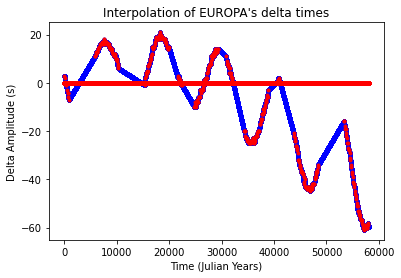

In [21]:
#cubic interpolation is actually way worse for the FFT part, so let's just do a simple linear one

hours_linspace = np.linspace(0, len(binned_eclipse_data_hours)-1, len(binned_eclipse_data_hours))

idx = np.nonzero(binned_eclipse_data_hours)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_hours[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(hours_linspace[:])

plt.plot(eclipse_data_interp, 'b.')
plt.plot(binned_eclipse_data_hours, 'r.')

plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time (Julian Years)')
plt.title('Interpolation of EUROPA\'s delta times')

with the interpolation we basically generate data where there is none, the underlayng assumption is that the data has to have a sin form

let's now petfrom an FFT on the data, this time with a special spectrum resolution

it looks like there are some clerar peaks

[ 197 1533]


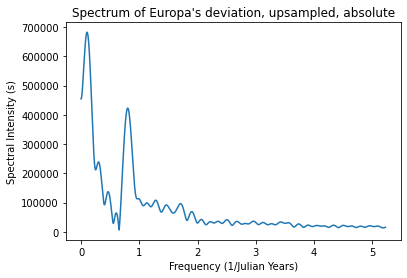

In [22]:
#zero pad for higher resolutioin
zero_pad = np.zeros(2**24-len(eclipse_data_interp))
s_interp = fft(np.append(eclipse_data_interp, zero_pad))

t_s = (1*3600)/(365.25*24*3600)

freq = np.fft.fftfreq(2**24, d=t_s)

plt.ylabel('Spectral Intensity (s)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of Europa\'s deviation, upsampled, absolute')
plt.plot(freq[0:10000], np.abs(s_interp[0:10000]))

peaks, _ = find_peaks(np.abs(s_interp[0:int(len(s_interp)/2)]), height=3*10**5)
print(peaks)

Frequency components : (1/Julian Years)
[0.10293138 0.80098379]


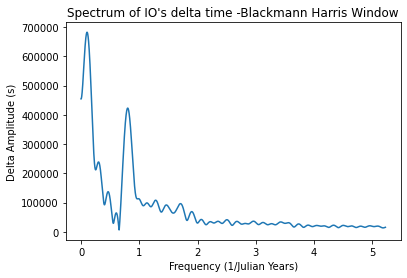

In [23]:
#here I will try to clean the signal using a window, actually we should see way less disturbances in the HF zone, nevertheless we are not really interested in it since they mainly come from the junp-function
w = windows.blackmanharris(len(eclipse_data_interp)) 

zero_pad = np.zeros(2**24-len(eclipse_data_interp))

s_interp_window = eclipse_data_interp*w

s_interp_zeropad_window = np.append(eclipse_data_interp,zero_pad)

s_interp = fft(s_interp_zeropad_window)

plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of IO\'s delta time -Blackmann Harris Window')

plt.plot(freq[0:10**4], np.abs(s_interp[0:10**4]))

peaks, _ = find_peaks(np.abs(s_interp[0:int(len(s_interp)/2)]), height=3*10**5)

print("Frequency components : (1/Julian Years)")

print(freq[peaks])

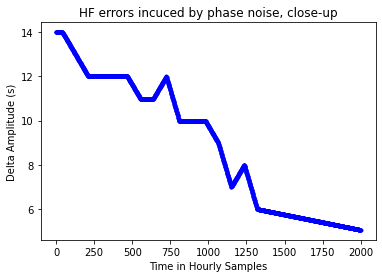

In [24]:
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in Hourly Samples')
plt.title('HF errors incuced by phase noise, close-up')

plt.plot(eclipse_data_interp[9000:11000], 'b.')

there is a lot of noise coming from this phenomena regarding the linear interpolation, we decrease the temporal resolution

let's try to reconstruct the signal back only using some of the harmonics up to the first peak(sample ~1500)

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part



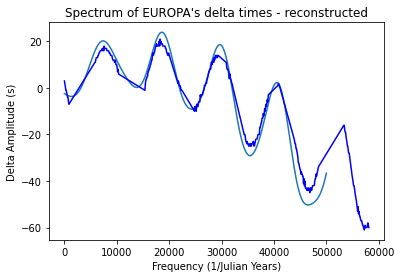

In [25]:
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of EUROPA\'s delta times - reconstructed')

plt.plot(ifft(np.append(s_interp[0:3*10**3], zero_pad)*2.5)[0:50*10**3])
plt.plot(eclipse_data_interp, 'b')

the reconstruction looks really fine, now switching to a daily resolution, the function needs to be multiplied with the jump function to obtain some acceptable results out of it, now we will compute the spectrum of the eclipse-delta function multiplied with the windowing function

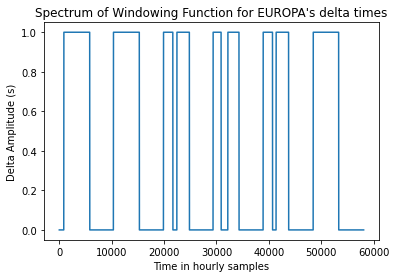

In [26]:
#twoi things are happening here : 
#1) downsampling of the windowing function
#2) the switchings will be way smoother, hence less HF effects 

np.append(s_t, zeropad_vec)

s_t_hrs = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    s_t_hrs[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])
    
    
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Spectrum of Windowing Function for EUROPA\'s delta times')
    
plt.plot(s_t_hrs)

Peaks at : (in 1/Julian Years)
[0.1013639  0.29886675 0.45352507 0.60295844 0.80620873 1.00475657
 1.20069194 1.33810794 1.50217116 1.69601655 1.98913586 2.50692773
 2.66524351 2.849684   3.54198897 3.84085572 4.49972105 4.68102658
 5.38482642 6.50662172]


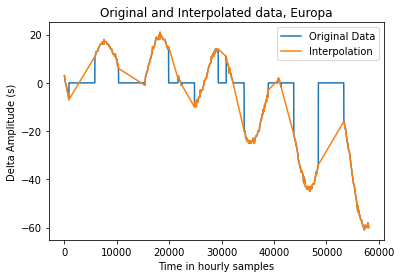

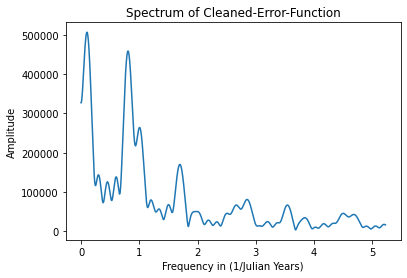

In [29]:
#now I will try to clean out the mess made by the windowing function by setting every element of the arry to zero where the windowing function happens to be

cleaned_array = eclipse_data_interp * (1-s_t_hrs)

plt.figure(1)
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Original and Interpolated data, Europa')

plt.plot(cleaned_array)
plt.plot(eclipse_data_interp)
plt.legend(['Original Data', 'Interpolation'])


#here I will perform an fft
s_cleaned = fft(np.append(cleaned_array, zero_pad))

plt.figure(2)

plt.ylabel('Amplitude')
plt.xlabel('Frequency in (1/Julian Years)')
plt.title('Spectrum of Cleaned-Error-Function')
plt.plot(freq[0:10**4], abs(s_cleaned[0:10**4]))

peaks, _ = find_peaks(np.abs(s_cleaned[0:int(len(s_cleaned)/2)]), height=3*10**4)
print('Peaks at : (in 1/Julian Years)')
print(freq[peaks])

Inserting the windowing function implies generating a lot of secondary peaks in the fourier transform, so this action actually has the effct of making the spectrumn of trhe signal much worse, and needs to be reverted, nevre the less I have tested a lot of things regaring the possibility of filling in the gaps with a function interpolated with a filter.

By chinging the cut-off frequency of the filter er get a more or less resposiveness. Every cut-off frequency we wanna use has the problem of acting like a PID-element reacting to a jump-function, and will generate any kind of artifact in the HF frequency range.

In [ ]:
#filter out the HF components resulting from the effect of rounding off to 1 sec

sos = sp.signal.cheby1(10, 0.001, 0.001, 'low', analog=False, output = 'sos')

filtered = sp.signal.sosfilt(sos, eclipse_data_interp*(1-s_t_hrs))

print(len(eclipse_data_interp))

plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Close up- HF noise filtered out')

plt.plot(filtered[9000:11000], 'b.')
plt.plot(eclipse_data_interp[9000:11000], 'r.')

In [ ]:
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Noisy and filtered error-curves compared')

plt.plot(filtered[:], 'b')
plt.plot(cleaned_array[:], 'r')

In [ ]:
s_cleaned_cheby = fft(np.append(filtered, zero_pad))

plt.ylabel('Amplitude')
plt.xlabel('Frequency in 1/(Julian Years)')
plt.title('Spectrum of noisy and filtered error-curves compared')

plt.plot(freq[0:5*10**4], np.abs(s_cleaned_cheby[0:5*10**4]))
plt.plot(freq[0:5*10**4], np.abs(s_cleaned[0:5*10**4]))

this is the spectrum of the jump-function, As it is nearly periodic, it clearlyhows the effct of windowind on it. (si(t)-function), As you can guess, convoluting them will clerly give us a "double peak" at around 1500 frequency bins. Mybe we should try chaingin the window

In [ ]:
plt.ylabel('Amplitude')
plt.xlabel('Frequency in 1/(Julian Years)')
plt.title('Spectrum of noisy and filtered error-curves compared')

fft_s_t_upsample = fft(np.append(1-s_t_hrs , zero_pad)) 
plt.plot(freq[0:10**4], np.abs(fft(np.append(eclipse_data_interp, zero_pad))[0:10**4]))
plt.plot(freq[0:10**4], np.abs(fft_s_t_upsample)[0:10**4]*10)
plt.plot(freq[0:10**4], np.abs(s_cleaned[0:10**4]))
plt.plot(freq[0:10**4] ,np.abs(s_cleaned_cheby[0:10**4]))

In [ ]:
#filter the interpolated data

filtered_interp = sp.signal.sosfilt(sos, eclipse_data_interp)
s_cleaned_cheby_interp = fft(np.append(filtered_interp, zero_pad))


plt.figure(1)
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Filterinf of the interpolaes signal')
plt.plot(filtered_interp)

plt.figure(2)
plt.ylabel('Amplitude')
plt.xlabel('Frequency in 1/(Julian Years)')
plt.title('Spectrum of noisy and filtered error-curves compared')

plt.plot(freq[0:10**4], np.abs(s_cleaned_cheby_interp[0:10**4]))

peaks, _ = find_peaks(np.abs(fft(np.append(filtered_interp, zero_pad))), height=4.5*10**4)
print('Peaks at : (in 1/Julian Years)')
print(freq[peaks])

Interrestingly enough, this windowing function gives almost the same spectrum as the origian function, this is a normal consequence of it near periodic behaviour

Well, apparently there is no advantage of filtering it all before we do the fft, I will just compute the correlatiopn function to make sure taht we did nothing wrong

In [ ]:
#curve fitting

def func(time, f_1, phi_1, amplitude_1, f_2, phi_2, amplitude_2, offset):

    return offset + amplitude_1*np.sin(f_1*2*np.pi*time/(24*365.25) + phi_1) + amplitude_2*np.sin(f_2*2*np.pi*time/(24*365.25) + phi_2)

hrs_linspace = np.linspace(0, len(s_t_hrs)-1, len(s_t_hrs))


mask = (1-s_t_hrs)

print(np.size(s_t_hrs))

mask = np.array(mask, dtype = 'bool')

print(mask)

values_w_nan = np.zeros(len(eclipse_data_interp))

values_w_nan[(1-s_t_hrs)==0] = np.nan
values_w_nan[(1-s_t_hrs)!=0] = eclipse_data_interp[(1-s_t_hrs)!=0]

popt_EUROPA, pcov = curve_fit(func, hrs_linspace[mask], eclipse_data_interp[mask], maxfev=10**4, 
                       bounds=([0.1,0,0,0.01,0,0,-7],[1.5, 2*np.pi, 100,0.5,2*np.pi,100,+10]), #0,25 actuall delibvers a better looking optiocal fit, don't know why
                       )#sigma = (1-s_t_days)+0.00001)

print("Parameters")
print(*popt_EUROPA)
print("Covariance")
print(pcov)

plt.ylabel('Amplitude (s)')
plt.xlabel('Time in Julian Years')
plt.title('Regression and original curve, Europa')
plt.plot(eclipse_data_interp[:])
plt.plot(func(hrs_linspace[:],*popt_EUROPA))
plt.legend(['Original Data', 'Regression'])

In [ ]:
def rmse_fit(time, f1, f2, phi_1, amplitude_1, phi_2, amplitude_2, offset, meas_data):
    return np.sqrt(np.sum(func(time, f1, phi_1, amplitude_1, f2, phi_2, amplitude_2, offset) - meas_data)**2)

points_per_side = 1*10**2

f_1_arr = np.linspace(-5, 5 ,points_per_side)
f_2_arr = np.linspace(-1, 1, points_per_side)

f1_v, f2_v = np.meshgrid(f_1_arr, f_2_arr, sparse=False, indexing='ij')

#['f_1', 'phi_1', 'amplitude_1', 'f_2', 'phi_2', 'amplitude_2', 'offset']

phi_1_gan = popt_EUROPA[1]
phi_2_gan = popt_EUROPA[4]
amplitude_1_gan = popt_EUROPA[2]
amplitude_2_gan =popt_EUROPA[5]
offset_gan = popt_EUROPA[6]

error_matrix = np.zeros([np.size(f_1_arr), np.size(f_1_arr)])

for i in range (np.size(f_1_arr)):
    
    for j in range (np.size(f_1_arr)):        
        
        error_matrix[i, j] = rmse_fit(hrs_linspace[mask], f1_v[i, j], f2_v[i, j], phi_1_gan, amplitude_1_gan, phi_2_gan, amplitude_2_gan, offset_gan,eclipse_data_interp[mask])

In [ ]:
fig_error_2d = px.imshow(error_matrix)
fig_error_2d.update_layout(title="EUROPA -2D Error Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_error_2d.show()

fig_inv_err_log_2d = px.imshow(np.log10(1/error_matrix))
fig_inv_err_log_2d.update_layout(title="EUROPA -2D Inv-Log-Error Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_inv_err_log_2d.show()

fig_error_3d = go.Figure(go.Surface(

    x = f_1_arr,
    y = f_2_arr,
    z = error_matrix

))
fig_error_3d.update_layout(title="EUROPA -3D Error Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_error_3d.show()

fig_exactness_3d = go.Figure(go.Surface(

    x = f_1_arr,
    y = f_2_arr,
    z = (1/error_matrix)

))
fig_exactness_3d.update_layout(title="EUROPA -3D Exactness Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_exactness_3d.show()

fig_exactness_3d.show()

# GANYMEDE

0              0.0
1         619103.0
2        1238187.0
3        1857285.0
4        2476423.0
          ...     
268    217935911.0
269    218555236.0
270    219174564.0
271    219793862.0
272    220413157.0
Name: DateTimeEventTT, Length: 273, dtype: float64


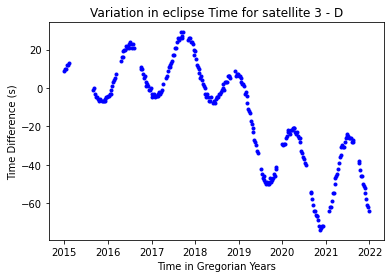

In [16]:
# create the dataframe from a query
df = pd.read_sql_query("SELECT * FROM Event", cnx)

sql_cmd = """

WITH

PyMeeus AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT, 
Satellite, Type1, Type2, Type3
FROM Event
WHERE ((Origin="PyMeeus") 
AND (Satellite == 3)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
)),

Thuillot AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT
FROM Event
WHERE ((Origin="Thuillot") 
AND (Satellite == 3)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
))


SELECT p.DateTimeEventTT, p.Satellite, p.Type1, p.Type2, p.Type3, 
strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) AS deltaTime, 
MIN( ABS( strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) )) AS minDeltaTime
FROM (PyMeeus p INNER JOIN Thuillot t
ON p.Type = t.Type)
GROUP BY p.DateTimeEventTT
HAVING minDeltaTime <= 3600

"""

df = pd.read_sql_query(sql_cmd, cnx)

#now do the same for europa --> load the data

df_EC_INT_GANYMEDE_INT= df[((df.Satellite == 3)&(df.Type1 == 'EC')&(df.Type2 == 'D')&(df.Type3 == 'INT'))]

df_EC_INT_GANYMEDE_INT= df_EC_INT_GANYMEDE_INT[[ 'DateTimeEventTT','deltaTime']]

dates_int = matplotlib.dates.date2num(df_EC_INT_GANYMEDE_INT['DateTimeEventTT'].to_numpy())
matplotlib.pyplot.plot_date(dates_int, df_EC_INT_GANYMEDE_INT['deltaTime'].to_numpy(), 'b.')

plt.ylabel('Time Difference (s)')
plt.xlabel('Time in Gregorian Years')
plt.title('Variation in eclipse Time for satellite 3 - D')

datetime_array = df_EC_INT_GANYMEDE_INT['DateTimeEventTT'].to_numpy()

df_unix_sec = pd.to_datetime(df_EC_INT_GANYMEDE_INT['DateTimeEventTT']).astype(int)/ 10**9

#print(df_unix_sec)

first_sampling_time = df_unix_sec[0]

relative_sampling_time = df_unix_sec - first_sampling_time

print(relative_sampling_time)

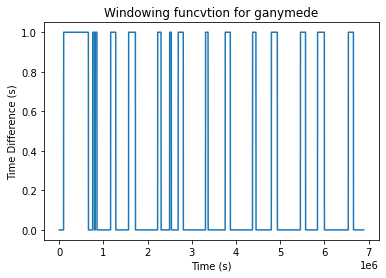

In [17]:
local_downsampling_factor = 32

#now we must find samples that are more than three days apart, usually the orbital period is somewhat like 6 days, so everything is ok

samples_diff_vec = np.zeros(len(relative_sampling_time)-1)

for i in range (len(relative_sampling_time)-1):

    samples_diff_vec[i] = relative_sampling_time[i+1] - relative_sampling_time[i]

    
#print(samples_diff_vec)

hot_positions = samples_diff_vec > 3600*24*10 #gaps > than 10 days

#print(hot_positions)

#identify positions limits for the s(t) function

s_limits = np.zeros(len(relative_sampling_time))


for i in range (len(hot_positions)):

    if(hot_positions[i]):
    
        s_limits[i] = relative_sampling_time[i]
        i = i+1
        s_limits[i] = relative_sampling_time[i]

#print(s_limits)

non_zero_indices = (np.nonzero(s_limits))[0]


#print(non_zero_indices)

s_t = np.zeros(int(max(relative_sampling_time)))

i = 0

while i in range(np.size(non_zero_indices)-1):
    
    l_index = non_zero_indices[i]
    #print(l_index)
    tmp = i+1
    i = i+1
    r_index = non_zero_indices[tmp]
    i = i+1

    #print(r_index)
    
    #print(int(relative_sampling_time[l_index]))
    #print(int(relative_sampling_time[r_index]))
    #print('---')
    
    for e in range(int(relative_sampling_time[l_index]), int(relative_sampling_time[r_index])):
        s_t[e] = 1.0
        #print(int(relative_sampling_time[l_index]))
        
        

#print(s_t)
 
#print(np.sum(s_t))

s_t_sparse=sparse.csr_matrix(s_t)


plt.ylabel('Time Difference (s)')
plt.xlabel('Time (s)')
plt.title('Windowing funcvtion for ganymede')
plt.plot(s_t[::local_downsampling_factor])    

Text(0.5, 1.0, "Spectrum of GANYMEDE's windowing function")

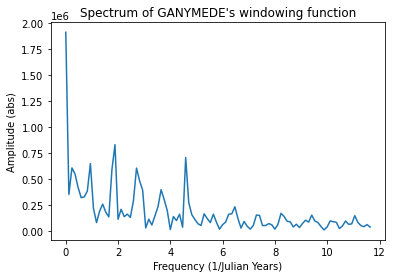

In [18]:
local_downsampling_factor = 32

#compute fft_size
fft_size = int(np.ceil(np.log2(len(s_t)/local_downsampling_factor)))

#sampling frequency in seconds
t_s = (1*local_downsampling_factor)/(365.25*24*3600)

freq = np.fft.fftfreq(2**fft_size, d=t_s)

s_jump_spectrum = fft(s_t[::local_downsampling_factor], 2**fft_size)

#only plot to 100 frequency bins, we are only interestd in the lowermost section of the spectrum
plt.plot(freq[0:100],np.abs(s_jump_spectrum[0:100]))

plt.ylabel('Amplitude (abs)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of GANYMEDE\'s windowing function')

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0.5, 1.0, "Spectrum of GANYMEDE's error function")

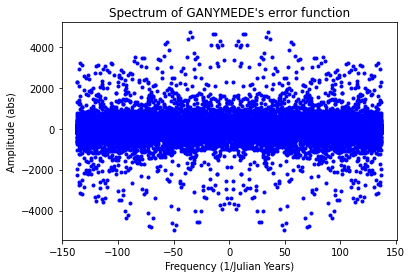

In [19]:
#now we have to generate the remianing data from the eclipse difference time data

eclipse_diff_data = np.zeros(int(max(relative_sampling_time)))


time_diff_data_sparse = df_EC_INT_GANYMEDE_INT['deltaTime'].to_numpy()


for i in range(len(relative_sampling_time)-1):
    
    timestamp = int(relative_sampling_time[i])
    
    eclipse_diff_data[timestamp] = time_diff_data_sparse[i]
    
#perform the FFT

n_samples_per_bin = 3600 #seconds in an hour, basic time bin units

binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

#print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_hours = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_hours[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])  
    
    
#perform the FFT on the binned data
fft_size = 2**int(np.ceil(np.log2(len(binned_eclipse_data_hours))))

s_spectrum = fft(binned_eclipse_data_hours[:], fft_size)

#sampling frequency in seconds
t_s = (1*3600*local_downsampling_factor)/(365.25*24*3600)
freq = np.fft.fftfreq(fft_size, d=t_s)

plt.plot(freq, s_spectrum[:], 'b.')

plt.ylabel('Amplitude (abs)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of GANYMEDE\'s error function')

Text(0.5, 1.0, "Interpolation of GANYMEDE's delta times")

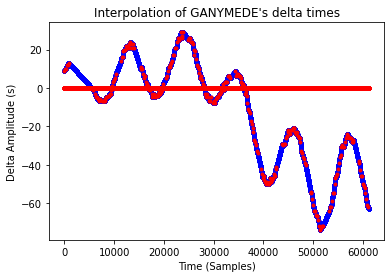

In [20]:
#cubic interpolation is actually way worse for the FFT part, so let's just do a simple linear one

hours_linspace = np.linspace(0, len(binned_eclipse_data_hours)-1, len(binned_eclipse_data_hours))

idx = np.nonzero(binned_eclipse_data_hours)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_hours[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(hours_linspace[:])

plt.plot(eclipse_data_interp, 'b.')
plt.plot(binned_eclipse_data_hours, 'r.')

plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time (Samples)')
plt.title('Interpolation of GANYMEDE\'s delta times')

with the interpolation we basically generate data where there is none, the underlayng assumption is that the data has to have a sin form

let's now petfrom an FFT on the data, this time with a special spectrum resolution

it looks like there are some clerar peaks

[ 198 1552]


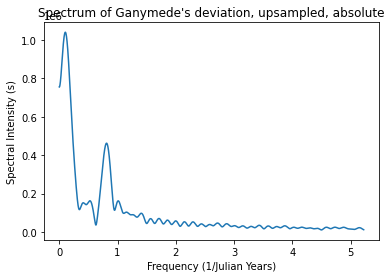

In [21]:
#zero pad for higher resolutioin
zero_pad = np.zeros(2**24-len(eclipse_data_interp))
s_interp = fft(np.append(eclipse_data_interp, zero_pad))

t_s = (1*3600)/(365.25*24*3600)

freq = np.fft.fftfreq(2**24, d=t_s)

plt.ylabel('Spectral Intensity (s)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of Ganymede\'s deviation, upsampled, absolute')
plt.plot(freq[0:10000], np.abs(s_interp[0:10000]))

peaks, _ = find_peaks(np.abs(s_interp[0:int(len(s_interp)/2)]), height=3*10**5)
print(peaks)

Frequency components : (1/Julian Years)
[0.10345387 0.81091118]


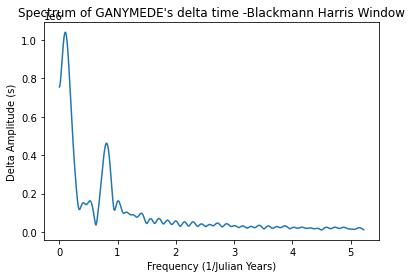

In [22]:
#here I will try to clean the signal using a window, actually we should see way less disturbances in the HF zone, nevertheless we are not really interested in it since they mainly come from the junp-function
w = windows.blackmanharris(len(eclipse_data_interp)) 

zero_pad = np.zeros(2**24-len(eclipse_data_interp))

s_interp_window = eclipse_data_interp*w

s_interp_zeropad_window = np.append(eclipse_data_interp,zero_pad)

s_interp = fft(s_interp_zeropad_window)

plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of GANYMEDE\'s delta time -Blackmann Harris Window')

plt.plot(freq[0:10**4], np.abs(s_interp[0:10**4]))

peaks, _ = find_peaks(np.abs(s_interp[0:int(len(s_interp)/2)]), height=3*10**5)

print("Frequency components : (1/Julian Years)")

print(freq[peaks])

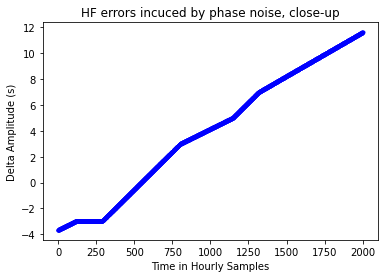

In [23]:
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in Hourly Samples')
plt.title('HF errors incuced by phase noise, close-up')

plt.plot(eclipse_data_interp[9000:11000], 'b.')

there is a lot of noise coming from this phenomena regarding the linear interpolation, we decrease the temporal resolution

let's try to reconstruct the signal back only using some of the harmonics up to the first peak(sample ~1500)

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part



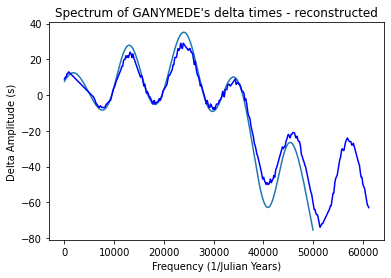

In [24]:
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Frequency (1/Julian Years)')
plt.title('Spectrum of GANYMEDE\'s delta times - reconstructed')

plt.plot(ifft(np.append(s_interp[0:3*10**3], zero_pad)*2.5)[0:50*10**3])
plt.plot(eclipse_data_interp, 'b')

the reconstruction looks really fine, now switching to a daily resolution, the function needs to be multiplied with the jump function to obtain some acceptable results out of it, now we will compute the spectrum of the eclipse-delta function multiplied with the windowing function

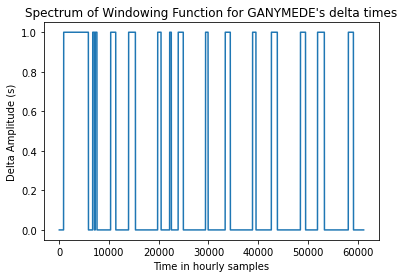

In [25]:
#two things are happening here : 
#1) downsampling of the windowing function
#2) the switchings will be way smoother, hence less HF effects 

np.append(s_t, zeropad_vec)

s_t_hrs = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    s_t_hrs[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])
    
    
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Spectrum of Windowing Function for GANYMEDE\'s delta times')
    
plt.plot(s_t_hrs)

Peaks at : (in 1/Julian Years)
[ 0.10293138  0.49480212  0.81613612  1.01520646  1.20330441  1.37102509
  1.52777338  1.71325886  1.94629133  2.14901912  2.26553535  2.6751709
  2.86431384  3.41606784  3.60573328  3.87586284  4.19040442  4.49763107
  4.71916866  5.43759835  5.77199471  6.30023646  7.04531336  7.48786604
  8.18226099  8.40954602  8.64153349  9.32861352  9.52245891 10.19020665
 10.4148792  11.38880861 11.59571636 11.86009848 14.00807261 16.05729532]


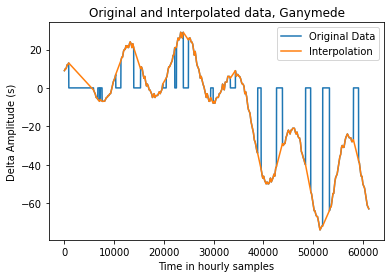

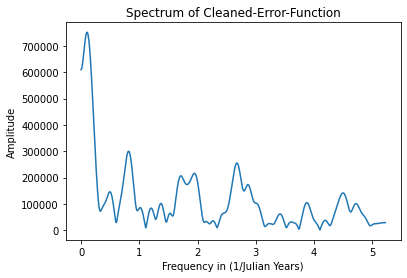

In [26]:
#now I will try to clean out the mess made by the windowing function by setting every element of the arry to zero where the windowing function happens to be

cleaned_array = eclipse_data_interp * (1-s_t_hrs)

plt.figure(1)
plt.ylabel('Delta Amplitude (s)')
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Original and Interpolated data, Ganymede')

plt.plot(cleaned_array)
plt.plot(eclipse_data_interp)
plt.legend(('Original Data', 'Interpolation'))

#here I will perform an fft
s_cleaned = fft(np.append(cleaned_array, zero_pad))

plt.figure(2)

plt.ylabel('Amplitude')
plt.xlabel('Frequency in (1/Julian Years)')
plt.title('Spectrum of Cleaned-Error-Function')
plt.plot(freq[0:10**4], abs(s_cleaned[0:10**4]))

peaks, _ = find_peaks(np.abs(s_cleaned[0:int(len(s_cleaned)/2)]), height=3*10**4)
print('Peaks at : (in 1/Julian Years)')
print(freq[peaks])

Inserting the windowing function implies generating a lot of secondary peaks in the fourier transform, so this action actually has the effct of making the spectrumn of trhe signal much worse, and needs to be reverted, nevre the less I have tested a lot of things regaring the possibility of filling in the gaps with a function interpolated with a filter.

By chinging the cut-off frequency of the filter er get a more or less resposiveness. Every cut-off frequency we wanna use has the problem of acting like a PID-element reacting to a jump-function, and will generate any kind of artifact in the HF frequency range.

In [ ]:
#filter out the HF components resulting from the effect of rounding off to 1 sec

sos = sp.signal.cheby1(10, 0.001, 0.001, 'low', analog=False, output = 'sos')

filtered = sp.signal.sosfilt(sos, eclipse_data_interp*(1-s_t_hrs))

print(len(eclipse_data_interp))

plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Close up- HF noise filtered out')

plt.plot(filtered[9000:11000], 'b.')
plt.plot(eclipse_data_interp[9000:11000], 'r.')

In [ ]:
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Noisy and filtered error-curves compared')

plt.plot(filtered[:], 'b')
plt.plot(cleaned_array[:], 'r')

In [ ]:
s_cleaned_cheby = fft(np.append(filtered, zero_pad))

plt.ylabel('Amplitude')
plt.xlabel('Frequency in 1/(Julian Years)')
plt.title('Spectrum of noisy and filtered error-curves compared')

plt.plot(freq[0:5*10**4], np.abs(s_cleaned_cheby[0:5*10**4]))
plt.plot(freq[0:5*10**4], np.abs(s_cleaned[0:5*10**4]))

this is the spectrum of the jump-function, As it is nearly periodic, it clearlyhows the effct of windowind on it. (si(t)-function), As you can guess, convoluting them will clerly give us a "double peak" at around 1500 frequency bins. Mybe we should try chaingin the window

In [ ]:
plt.ylabel('Amplitude')
plt.xlabel('Frequency in 1/(Julian Years)')
plt.title('Spectrum of noisy and filtered error-curves compared')

fft_s_t_upsample = fft(np.append(1-s_t_hrs , zero_pad)) 
plt.plot(freq[0:10**4], np.abs(fft(np.append(eclipse_data_interp, zero_pad))[0:10**4]))
plt.plot(freq[0:10**4], np.abs(fft_s_t_upsample)[0:10**4]*10)
plt.plot(freq[0:10**4], np.abs(s_cleaned[0:10**4]))
plt.plot(freq[0:10**4] ,np.abs(s_cleaned_cheby[0:10**4]))

In [ ]:
#filter the interpolated data

filtered_interp = sp.signal.sosfilt(sos, eclipse_data_interp)
s_cleaned_cheby_interp = fft(np.append(filtered_interp, zero_pad))


plt.figure(1)
plt.ylabel('Delta Amplitude (s)')
plt.xlabel('Time in hourly samples')
plt.title('Filterinf of the interpolaes signal')
plt.plot(filtered_interp)

plt.figure(2)
plt.ylabel('Amplitude')
plt.xlabel('Frequency in 1/(Julian Years)')
plt.title('Spectrum of noisy and filtered error-curves compared')

plt.plot(freq[0:10**4], np.abs(s_cleaned_cheby_interp[0:10**4]))

peaks, _ = find_peaks(np.abs(fft(np.append(filtered_interp, zero_pad))), height=4.5*10**4)
print('Peaks at : (in 1/Julian Years)')
print(freq[peaks])

Interrestingly enough, this windowing function gives almost the same spectrum as the origian function, this is a normal consequence of it near periodic behaviour

Well, apparently there is no advantage of filtering it all before we do the fft, I will just compute the correlatiopn function to make sure taht we did nothing wrong

In [ ]:
#curve fitting

def func(time, f_1, phi_1, amplitude_1, f_2, phi_2, amplitude_2, offset):

    return offset + amplitude_1*np.sin(f_1*2*np.pi*time/(24*365.25) + phi_1) + amplitude_2*np.sin(f_2*2*np.pi*time/(24*365.25) + phi_2)

hrs_linspace = np.linspace(0, len(s_t_hrs)-1, len(s_t_hrs))


mask = (1-s_t_hrs)

print(np.size(s_t_hrs))

mask = np.array(mask, dtype = 'bool')

print(mask)

values_w_nan = np.zeros(len(eclipse_data_interp))

values_w_nan[(1-s_t_hrs)==0] = np.nan
values_w_nan[(1-s_t_hrs)!=0] = eclipse_data_interp[(1-s_t_hrs)!=0]

popt_GANYMEDE, pcov = curve_fit(func, hrs_linspace[mask], eclipse_data_interp[mask], maxfev=10**4, 
                       bounds=([0.1,0,10,0.05,0,17,-20],[1.5, 2*np.pi, 30,0.18,2*np.pi,50,+20]), #0,25 actuall delibvers a better looking optiocal fit, don't know why
                       )#sigma = (1-s_t_days)+0.00001)

print("Parameters")
print(*popt_GANYMEDE)
print("Covariance")
print(pcov)

plt.ylabel('Amplitude (s)')
plt.xlabel('Time in Julian Years')
plt.title('Regression and original curve, Ganymede')
plt.plot(eclipse_data_interp[:])
plt.plot(func(hrs_linspace[:],*popt_GANYMEDE))
plt.legend(('Original Data', 'Regression'))

In [43]:
def rmse_fit(time, f1, f2, phi_1, amplitude_1, phi_2, amplitude_2, offset, meas_data):
    return np.sqrt(np.sum(func(time, f1, phi_1, amplitude_1, f2, phi_2, amplitude_2, offset) - meas_data)**2)

points_per_side = 1*10**2

f_1_arr = np.linspace(-5, 5 ,points_per_side)
f_2_arr = np.linspace(-1, 1, points_per_side)

f1_v, f2_v = np.meshgrid(f_1_arr, f_2_arr, sparse=False, indexing='ij')

#['f_1', 'phi_1', 'amplitude_1', 'f_2', 'phi_2', 'amplitude_2', 'offset']

phi_1_gan = popt_GANYMEDE[1]
phi_2_gan = popt_GANYMEDE[4]
amplitude_1_gan = popt_GANYMEDE[2]
amplitude_2_gan =popt_GANYMEDE[5]
offset_gan = popt_GANYMEDE[6]

error_matrix = np.zeros([np.size(f_1_arr), np.size(f_1_arr)])

for i in range (np.size(f_1_arr)):
    
    for j in range (np.size(f_1_arr)):        
        
        error_matrix[i, j] = rmse_fit(hrs_linspace[mask], f1_v[i, j], f2_v[i, j], phi_1_gan, amplitude_1_gan, phi_2_gan, amplitude_2_gan, offset_gan,eclipse_data_interp[mask])

In [44]:
fig_error_2d = px.imshow(error_matrix)
fig_error_2d.update_layout(title="GANYMEDE -2D Error Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_error_2d.show()

fig_inv_err_log_2d = px.imshow(np.log10(1/error_matrix))
fig_inv_err_log_2d.update_layout(title="GANYMEDE -2D Inv-Log-Error Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_inv_err_log_2d.show()

fig_error_3d = go.Figure(go.Surface(

    x = f_1_arr,
    y = f_2_arr,
    z = error_matrix

))
fig_error_3d.update_layout(title="GANYMEDE -3D Error Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_error_3d.show()

fig_exactness_3d = go.Figure(go.Surface(

    x = f_1_arr,
    y = f_2_arr,
    z = (1/error_matrix)

))
fig_exactness_3d.update_layout(title="GANYMEDE -3D Exactness Function" , xaxis={'title': 'f_1 in 1/Julian-Years [-5 to 5]'}, yaxis={'title': 'f_2 in 1/Julian-Years [-1 to 1]'})
fig_exactness_3d.show()

fig_exactness_3d.show()

# CALLISTO

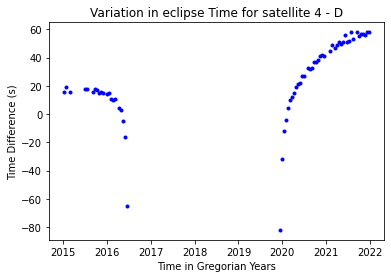

In [58]:
# create the dataframe from a query
df = pd.read_sql_query("SELECT * FROM Event", cnx)

sql_cmd = """

WITH

PyMeeus AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT, 
Satellite, Type1, Type2, Type3
FROM Event
WHERE ((Origin="PyMeeus") 
AND (Satellite == 4)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
)),

Thuillot AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT
FROM Event
WHERE ((Origin="Thuillot") 
AND (Satellite == 4)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
))


SELECT p.DateTimeEventTT, p.Satellite, p.Type1, p.Type2, p.Type3, 
strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) AS deltaTime, 
MIN( ABS( strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) )) AS minDeltaTime
FROM (PyMeeus p INNER JOIN Thuillot t
ON p.Type = t.Type)
GROUP BY p.DateTimeEventTT
HAVING minDeltaTime <= 3600

"""

df = pd.read_sql_query(sql_cmd, cnx)

#now do the same for europa --> load the data

df_EC_INT_CALLISTO_INT= df[((df.Satellite == 4)&(df.Type1 == 'EC')&(df.Type2 == 'D')&(df.Type3 == 'INT'))]

df_EC_INT_CALLISTO_INT= df_EC_INT_CALLISTO_INT[[ 'DateTimeEventTT','deltaTime']]

dates_int = matplotlib.dates.date2num(df_EC_INT_CALLISTO_INT['DateTimeEventTT'].to_numpy())
matplotlib.pyplot.plot_date(dates_int, df_EC_INT_CALLISTO_INT['deltaTime'].to_numpy(), 'b.')

plt.ylabel('Time Difference (s)')
plt.xlabel('Time in Gregorian Years')
plt.title('Variation in eclipse Time for satellite 4 - D')

datetime_array = df_EC_INT_CALLISTO_INT['DateTimeEventTT'].to_numpy()

df_unix_sec = pd.to_datetime(df_EC_INT_CALLISTO_INT['DateTimeEventTT']).astype(int)/ 10**9

#print(df_unix_sec)

first_sampling_time = df_unix_sec[0]

relative_sampling_time = df_unix_sec - first_sampling_time

#print(relative_sampling_time)

for ganymede things are way more different than the other moons. As I was expecting the variation degenerates from a periodic to a non periodic one since it is on the very upper-edge of the ellispoid's projection

# GENERAL DATA ANALYSIS

In [25]:
# I will now begin to analyte the gathered data and try to understand if there is some kind of dependancy between them

opt_matrix = np.array([[*popt_IO],[*popt_EUROPA],[*popt_GANYMEDE]])

param_names = ['f_1', 'phi_1', 'amplitude_1', 'f_2', 'phi_2', 'amplitude_2', 'offset']

moon_names = ['IO','EUROPA','GANYMEDE']

for i in range(len(param_names)):
    print(param_names[i])
    
    for a in range(len(moon_names)):
        print(moon_names[a] + " : ")
        print(opt_matrix[a, i])
        
    print("-.-.-.-.-.-.-.-.-.-.-.-.-.-")

NameError: name 'popt_IO' is not defined

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=opt_matrix[0, :],
      theta=param_names,
      fill='toself',
      name='IO'
))

fig.add_trace(go.Scatterpolar(
      r=opt_matrix[1, :],
      theta=param_names,
      fill='toself',
      name='EUROPA'
))
         
fig.add_trace(go.Scatterpolar(
      r=opt_matrix[2, :],
      theta=param_names,
      fill='toself',
      name='GANYMEDE'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 40]
    )),
  showlegend=False
)

fig.show()

In [ ]:
import pymeeus ad pm


epoch = pm.Epoch(2015, 0, 0, 0) # this should be in terrestrial time, not utc

epoch.set(2015, 1, 1, 0, 0, 0, utc = True) # this should be in terrestrial time, not utc


# 1 jd
time_step = 1

theta_arr = np.zeros(365*10)
phi_arr = np.zeros(365*10)

for i in range(365*10):

    epoch += time_step
    phi_arr[i], theta_arr[i] = pm.JupiterMoons.rotational_axis_angles(epoch)


